<h1 style="font-size:30px;">Fine-tuning YOLOv8 Pose Models for Animal Pose Estimation</h1>

In this blog post, we will specifically deal with keypoints estimation of **dogs** and show you how to fine-tune the very popular **YOLOv8** pose models from Ultralytics.

## Table of Contents

* [1 The Stanford Dogs Dataset](#1-The-Stanford-Dogs-Dataset)
* [2 Download Image Data and Keypoint Metadata](#2-Download-Image-Data-and-Keypoint-Metadata)
* [3 Create YOLO Train and Valid Directories](#3-Create-YOLO-Train-and-Valid-Directories)
* [4 Data Visualization](#4-Data-Visualization)
* [5 Configurations](#5-Configurations)
* [6 Training](#6-Training)
* [7 Evaluation](#7-Evaluation)
* [8 Predictions](#8-Predictions)

In [26]:
# !pip install -q tensorboard ultralytics

In [27]:
import os
import time
import json
import requests
from zipfile import ZipFile
import tarfile
from shutil import copyfile
from dataclasses import dataclass, field

import yaml
import glob

import random
import numpy as np
import pandas as pd
import cv2

from ultralytics import YOLO

import matplotlib.pyplot as plt

## 1 The Stanford Dogs Dataset

For our experiments, we will use the **Stanford Dataset**, which contains 120 breeds of dogs across **20,580** images. Besides, the dataset also contains the bounding box annotations for these images.

However, the keypoint annotations need to be downloaded from the **StandfordExtra** dataset by filling up a **[google form](https://forms.gle/sRtbicgxsWvRtRmUA)**. The keypoint annotations are provided across **12,538** images for `20` keypoints of dog pose (`3` for each leg, `2` for each ear, `2` for the tail, nose, and jaw).


The authors have also provided keypoint metadata in the form of a CSV file containing the animal pose name, the color coding for each keypoint, etc. It, however, contains the info across 2

## 2 Download Image Data and Keypoint Metadata

The `download_and_unzip` utility downloads and extracts the **`images.tar`** file containing the images. Besides, we shall also download the **`keypoint_definitions.csv`** containing the keypoint metadata, such as the animal pose name, color coding for each keypoint, etc., across all 24  keypoints.

In [28]:
# Download and dataset.
def download_and_unzip(url, save_path):

    print("Downloading and extracting assets...", end="")
    file = requests.get(url)
    open(save_path, "wb").write(file.content)

    try:
        # Extract tarfile.
        if save_path.endswith(".tar"):
            with tarfile.open(save_path, "r") as tar:
                tar.extractall(os.path.split(save_path)[0])

        print("Done")
    except:
        print("Invalid file")

All the downloaded images are extracted to the Images  directory. It has the following directory structure:

```python
Images/
├── n02085620-Chihuahua
│   ├── n02085620_10074.jpg
│   ├── n02085620_10131.jpg
│   └── ...
├── n02085782-Japanese_spaniel
│   ├── n02085782_1039.jpg
│   ├── n02085782_1058.jpg
│   └── n02085782_962.jpg
└── ...
```

In [29]:
IMAGES_URL = r"http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
IMAGES_DIR = "Images"
IMAGES_TAR_PATH = os.path.join(os.getcwd(), f"{IMAGES_DIR}.tar")

ANNS_METADATA_URL = r"https://github.com/benjiebob/StanfordExtra/raw/master/keypoint_definitions.csv"
ANNS_METADATA = "keypoint_definitions.csv"

# Download if dataset does not exists.
if not os.path.exists(IMAGES_DIR):
    download_and_unzip(IMAGES_URL, IMAGES_TAR_PATH)
    os.remove(IMAGES_TAR_PATH)

if not os.path.isfile(ANNS_METADATA):
    download_and_unzip(ANNS_METADATA_URL, ANNS_METADATA)

The annotations downloaded after filling out the form mentioned earlier are maintained in the `StanfordExtra_V12` directory which contains the annotation **JSON** file: `StanfordExtra_v12.json` contain the following structure:

```python
StanfordExtra_V12
├── StanfordExtra_v12.json
├── test_stanford_StanfordExtra_v12.npy
├── train_stanford_StanfordExtra_v12.npy
└── val_stanford_StanfordExtra_v12.npy
```

The train, validation, and test splits are provided as indices from the original **`StanfordExtra_v12.json`** data.

The train, validation, and test sets contain annotations for **6773**, **4062**, and **1703** images, respectively.

In [30]:
ANN_PATH = "StanfordExtra_V12"
JSON_PATH = os.path.join(ANN_PATH, "StanfordExtra_v12.json")

with open(JSON_PATH) as file:
    json_data = json.load(file)

The files: **`train_stanford_StanfordExtra_v12.npy`** and **`test_stanford_StanfordExtra_v12.npy`** consist of the training and validation indices with respect to the original json_data list.

For simplicity, we shall use the test data for validation. The training and the test sets comprise **6773** and **1703** samples, respectively.

In [31]:
train_ids = np.load(os.path.join(ANN_PATH,
                                 "train_stanford_StanfordExtra_v12.npy"))
val_ids = np.load(os.path.join(ANN_PATH,
                               "test_stanford_StanfordExtra_v12.npy"))

print(f"Train Samples: {len(train_ids)}")
print(f"Validation Samples: {len(val_ids)}")

Train Samples: 6773
Validation Samples: 1703


## 3 Create YOLO Train and Valid Directories

We will maintain the following directory structure for YOLOv8 dataset:

```python
animal-pose-data
├── train
│   ├── images (6773 files)
│   └── labels (6773 files)
└── valid
    ├── images (1703 files)
    └── labels (1703 files)
```

In [32]:
DATA_DIR = "animal-pose-data"

TRAIN_DIR         = f"train"
TRAIN_FOLDER_IMG    = f"images"
TRAIN_FOLDER_LABELS = f"labels"

TRAIN_IMG_PATH   = os.path.join(DATA_DIR, TRAIN_DIR, TRAIN_FOLDER_IMG)
TRAIN_LABEL_PATH = os.path.join(DATA_DIR, TRAIN_DIR, TRAIN_FOLDER_LABELS)

VALID_DIR           = f"valid"
VALID_FOLDER_IMG    = f"images"
VALID_FOLDER_LABELS = f"labels"

VALID_IMG_PATH   = os.path.join(DATA_DIR, VALID_DIR, VALID_FOLDER_IMG)
VALID_LABEL_PATH = os.path.join(DATA_DIR, VALID_DIR, VALID_FOLDER_LABELS)

os.makedirs(TRAIN_IMG_PATH, exist_ok=True)
os.makedirs(TRAIN_LABEL_PATH, exist_ok=True)
os.makedirs(VALID_IMG_PATH, exist_ok=True)
os.makedirs(VALID_LABEL_PATH, exist_ok=True)

Next, we will use `train_ids` and `val_ids` to gather the image and annotation data using `json_data` obtained earlier.

In [33]:
# TODO : decrese the number of training images to few tens
train_json_data = []
train_id_max_count=10
count=0
print("train ids")
for train_id in train_ids:
    train_json_data.append(json_data[train_id])
    count+=1
    print(f"{train_id=}")
    if count>=train_id_max_count:
        break

print("val ids")
val_json_data = []
for val_id in val_ids:
    val_json_data.append(json_data[val_id])
    print(f"{val_id=}")

train ids
train_id=910
train_id=917
train_id=920
train_id=926
train_id=928
train_id=931
train_id=939
train_id=952
train_id=956
train_id=985
val ids
val_id=944
val_id=974
val_id=976
val_id=999
val_id=1066
val_id=1197
val_id=1211
val_id=1231
val_id=1237
val_id=1277
val_id=1290
val_id=1348
val_id=1356
val_id=1362
val_id=0
val_id=49
val_id=94
val_id=117
val_id=171
val_id=211
val_id=258
val_id=1654
val_id=1667
val_id=1674
val_id=307
val_id=314
val_id=332
val_id=370
val_id=440
val_id=463
val_id=513
val_id=537
val_id=563
val_id=608
val_id=685
val_id=772
val_id=789
val_id=798
val_id=906
val_id=921
val_id=936
val_id=1056
val_id=1103
val_id=1148
val_id=1170
val_id=1195
val_id=1227
val_id=1243
val_id=1268
val_id=1335
val_id=1402
val_id=1445
val_id=1470
val_id=1482
val_id=1491
val_id=1527
val_id=876
val_id=877
val_id=897
val_id=961
val_id=983
val_id=998
val_id=1013
val_id=1025
val_id=1037
val_id=1090
val_id=1136
val_id=1192
val_id=1228
val_id=1239
val_id=1270
val_id=1551
val_id=1568
val_id=1571
va

### 3.1 Copy Image files

In [34]:
for data in train_json_data:
    img_file = data["img_path"]
    filename = img_file.split("/")[-1]
    copyfile(os.path.join(IMAGES_DIR, img_file),
             os.path.join(TRAIN_IMG_PATH, filename))


for data in val_json_data:
    img_file = data["img_path"]
    filename = img_file.split("/")[-1]
    copyfile(os.path.join(IMAGES_DIR, img_file),
             os.path.join(VALID_IMG_PATH, filename))

### 3.2 Create YOLO Annotation TXT FILES

Our final task for data preparation is to create the boxes and the keypoint annotations in accordance with Ultralytics’ YOLO. Since we will deal with a single class (i.e., dogs), we set the class index to **`0`**.

In [35]:
CLASS_ID = 0

The function **`create_yolo_boxes_kpts`** performs the following tasks:

* Modifies visibility indicators for keypoints (setting the visibilities for labeled keypoints to 2).
* Normalizes the coordinates of both bounding boxes and keypoints relative to the image dimensions.
* Converts bounding boxes to $[x_{center}, \ , y_{center},\ width,\ height]$ in normalized form.

In [36]:
def create_yolo_boxes_kpts(img_size, boxes, lm_kpts):

    IMG_W, IMG_H = img_size
    # Modify kpts with visibilities as 1s to 2s.
    vis_ones = np.where(lm_kpts[:, -1] == 1.)
    lm_kpts[vis_ones, -1] = 2.

    # Normalizing factor for bboxes and kpts.
    res_box_array = np.array([IMG_W, IMG_H, IMG_W, IMG_H])
    res_lm_array = np.array([IMG_W, IMG_H])

    # Normalize landmarks in the range [0,1].
    norm_kps_per_img = lm_kpts.copy()
    norm_kps_per_img[:, :-1]  = norm_kps_per_img[:, :-1] / res_lm_array

    # Normalize bboxes in the range [0,1].
    norm_bbox_per_img = boxes / res_box_array

    # Create bboxes coordinates to YOLO.
    # x_c, y_c = x_min + bbox_w/2. , y_min + bbox_h/2.
    yolo_boxes = norm_bbox_per_img.copy()
    yolo_boxes[:2] = norm_bbox_per_img[:2] + norm_bbox_per_img[2:]/2.

    return yolo_boxes, norm_kps_per_img

We will finally create the `txt` files for YOLO based on the `train_json_data` and `val_json_data` obtained earlier. The function `create_yolo_txt_files` creates the required `txt` annotations in YOLO using the `create_yolo_boxes_kpts` utility function explained above.

In [37]:
def create_yolo_txt_files(json_data, LABEL_PATH):

    for data in json_data:

        IMAGE_ID = data["img_path"].split("/")[-1].split(".")[0]

        IMG_WIDTH, IMG_HEIGHT = data["img_width"], data["img_height"]

        landmark_kpts  = np.nan_to_num(np.array(data["joints"], dtype=np.float32))
        landmarks_bboxes = np.array(data["img_bbox"], dtype=np.float32)

        bboxes_yolo, kpts_yolo = create_yolo_boxes_kpts(
                                            (IMG_WIDTH, IMG_HEIGHT),
                                            landmarks_bboxes,
                                            landmark_kpts)

        TXT_FILE = IMAGE_ID+".txt"

        with open(os.path.join(LABEL_PATH, TXT_FILE), "w") as f:

            x_c_norm, y_c_norm, box_width_norm, box_height_norm = round(bboxes_yolo[0],5),\
                                                                  round(bboxes_yolo[1],5),\
                                                                  round(bboxes_yolo[2],5),\
                                                                  round(bboxes_yolo[3],5),\

            kps_flattend = [round(ele,5) for ele in kpts_yolo.flatten().tolist()]
            line = f"{CLASS_ID} {x_c_norm} {y_c_norm} {box_width_norm} {box_height_norm} "
            line+= " ".join(map(str, kps_flattend))
            f.write(line)

Finnally, we create the train and validation data.

In [38]:
create_yolo_txt_files(train_json_data, TRAIN_LABEL_PATH)
create_yolo_txt_files(val_json_data, VALID_LABEL_PATH)

## 4 Data Visualization

Before visualizing the samples, we can map the `hexadecimal` color codings available with **`keypoint_definitions.csv`** to RGB values.

In [39]:
ann_meta_data = pd.read_csv("keypoint_definitions.csv")
COLORS = ann_meta_data["Hex colour"].values.tolist()

COLORS_RGB_MAP = []
for color in COLORS:
    R, G, B = int(color[:2], 16), int(color[2:4], 16), int(color[4:], 16)
    COLORS_RGB_MAP.append({color: (R,G,B)})

In [40]:
train_images = os.listdir(TRAIN_IMG_PATH)
valid_images = os.listdir(VALID_IMG_PATH)

print(f"Training images: {len(train_images)}, Validation Images: {len(valid_images)}")

Training images: 10, Validation Images: 1703


The `draw_landmarks` function is used to annotate the corresponding landmark points on the image using COLORS_RGB_MAP.

In [41]:
def draw_landmarks(image, landmarks):

    radius = 5
    # Check if image width is greater than 1000 px.
    # To improve visualization.
    if (image.shape[1] > 1000):
        radius = 8

    for idx, kpt_data in enumerate(landmarks):

        loc_x, loc_y = kpt_data[:2].astype("int").tolist()
        color_id = list(COLORS_RGB_MAP[int(kpt_data[-1])].values())[0]

        cv2.circle(image,
                   (loc_x, loc_y),
                   radius,
                   color=color_id[::-1],
                   thickness=-1,
                   lineType=cv2.LINE_AA)

    return image

The `draw_boxes` function is used to annotate the bounding boxes along with the confidence scores (if passed) on the image.

In [42]:
def draw_boxes(image, detections, class_name = "dog", score=None, color=(0,255,0)):

    font_size = 0.25 + 0.07 * min(image.shape[:2]) / 100
    font_size = max(font_size, 0.5)
    font_size = min(font_size, 0.8)
    text_offset = 3

    thickness = 2
    # Check if image width is greater than 1000 px.
    # To improve visualization.
    if (image.shape[1] > 1000):
        thickness = 10

    xmin, ymin, xmax, ymax = detections[:4].astype("int").tolist()
    conf = round(float(detections[-1]),2)
    cv2.rectangle(image,
                  (xmin, ymin),
                  (xmax, ymax),
                  color=(0,255,0),
                  thickness=thickness,
                  lineType=cv2.LINE_AA)

    display_text = f"{class_name}"

    if score is not None:
        display_text+=f": {score:.2f}"

    (text_width, text_height), _ = cv2.getTextSize(display_text,
                                                   cv2.FONT_HERSHEY_SIMPLEX,
                                                   font_size, 2)

    cv2.rectangle(image,
                      (xmin, ymin),
                      (xmin + text_width + text_offset, ymin - text_height - int(15 * font_size)),
                      color=color, thickness=-1)

    image = cv2.putText(
                    image,
                    display_text,
                    (xmin + text_offset, ymin - int(10 * font_size)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    font_size,
                    (0, 0, 0),
                    2, lineType=cv2.LINE_AA,
                )

    return image

The `visualize_annotations` is used to annotate both the bounding box coordinates and the landmark keypoints on the corresponding image after converting them to absoulute coordinates.

Recall that both the bounding box coordinates and the keypoints were normalized in the range `[0, 1]`. However, to plot them, we need the absolute coordinates.

The conversion mapping from YOLO bboxes to $[x_{min}, y_{min}, x_{max}, y_{max}]$ is pretty straight forward and can be obtained using the following set of equations:

$$x_{min} = \frac{W}{2} (2x_{center} \ - \ width)$$

$$y_{min} = \frac{H}{2} (2y_{center} \ - \ height)$$

$$x_{max} = x_{min} + width * W$$

$$y_{max} = y_{min} + height * H$$


Similarly, the keypoints can denormalized (to the absolute coordinates) using:

$$x_{abs} = x_{norm}* W$$

$$y_{abs} = y_{norm}* H$$


Here, the `width` and `height` are the box width and height respectively; whereas `W` and `H` are the image width and height respectively.

In [43]:
def visualize_annotations(image, box_data, keypoints_data):

    image = image.copy()

    shape_multiplier = np.array(image.shape[:2][::-1]) # (W, H).
    # Final absolute coordinates (xmin, ymin, xmax, ymax).
    denorm_boxes = np.zeros_like(box_data)

    # De-normalize center coordinates from YOLO to (xmin, ymin).
    denorm_boxes[:, :2] = (shape_multiplier/2.) * (2*box_data[:,:2] - box_data[:,2:])

    # De-normalize width and height from YOLO to (xmax, ymax).
    denorm_boxes[:, 2:] = denorm_boxes[:,:2] + box_data[:,2:]*shape_multiplier

    for boxes, kpts in zip(denorm_boxes, keypoints_data):
        # De-normalize landmark coordinates.
        kpts[:, :2]*= shape_multiplier
        image = draw_boxes(image, boxes)
        image = draw_landmarks(image, kpts)

    return image

The following plot shows a few image samples with their corresponding ground truth annotation. The keypoint annotations are filtered based on their corresponding visibility flag.

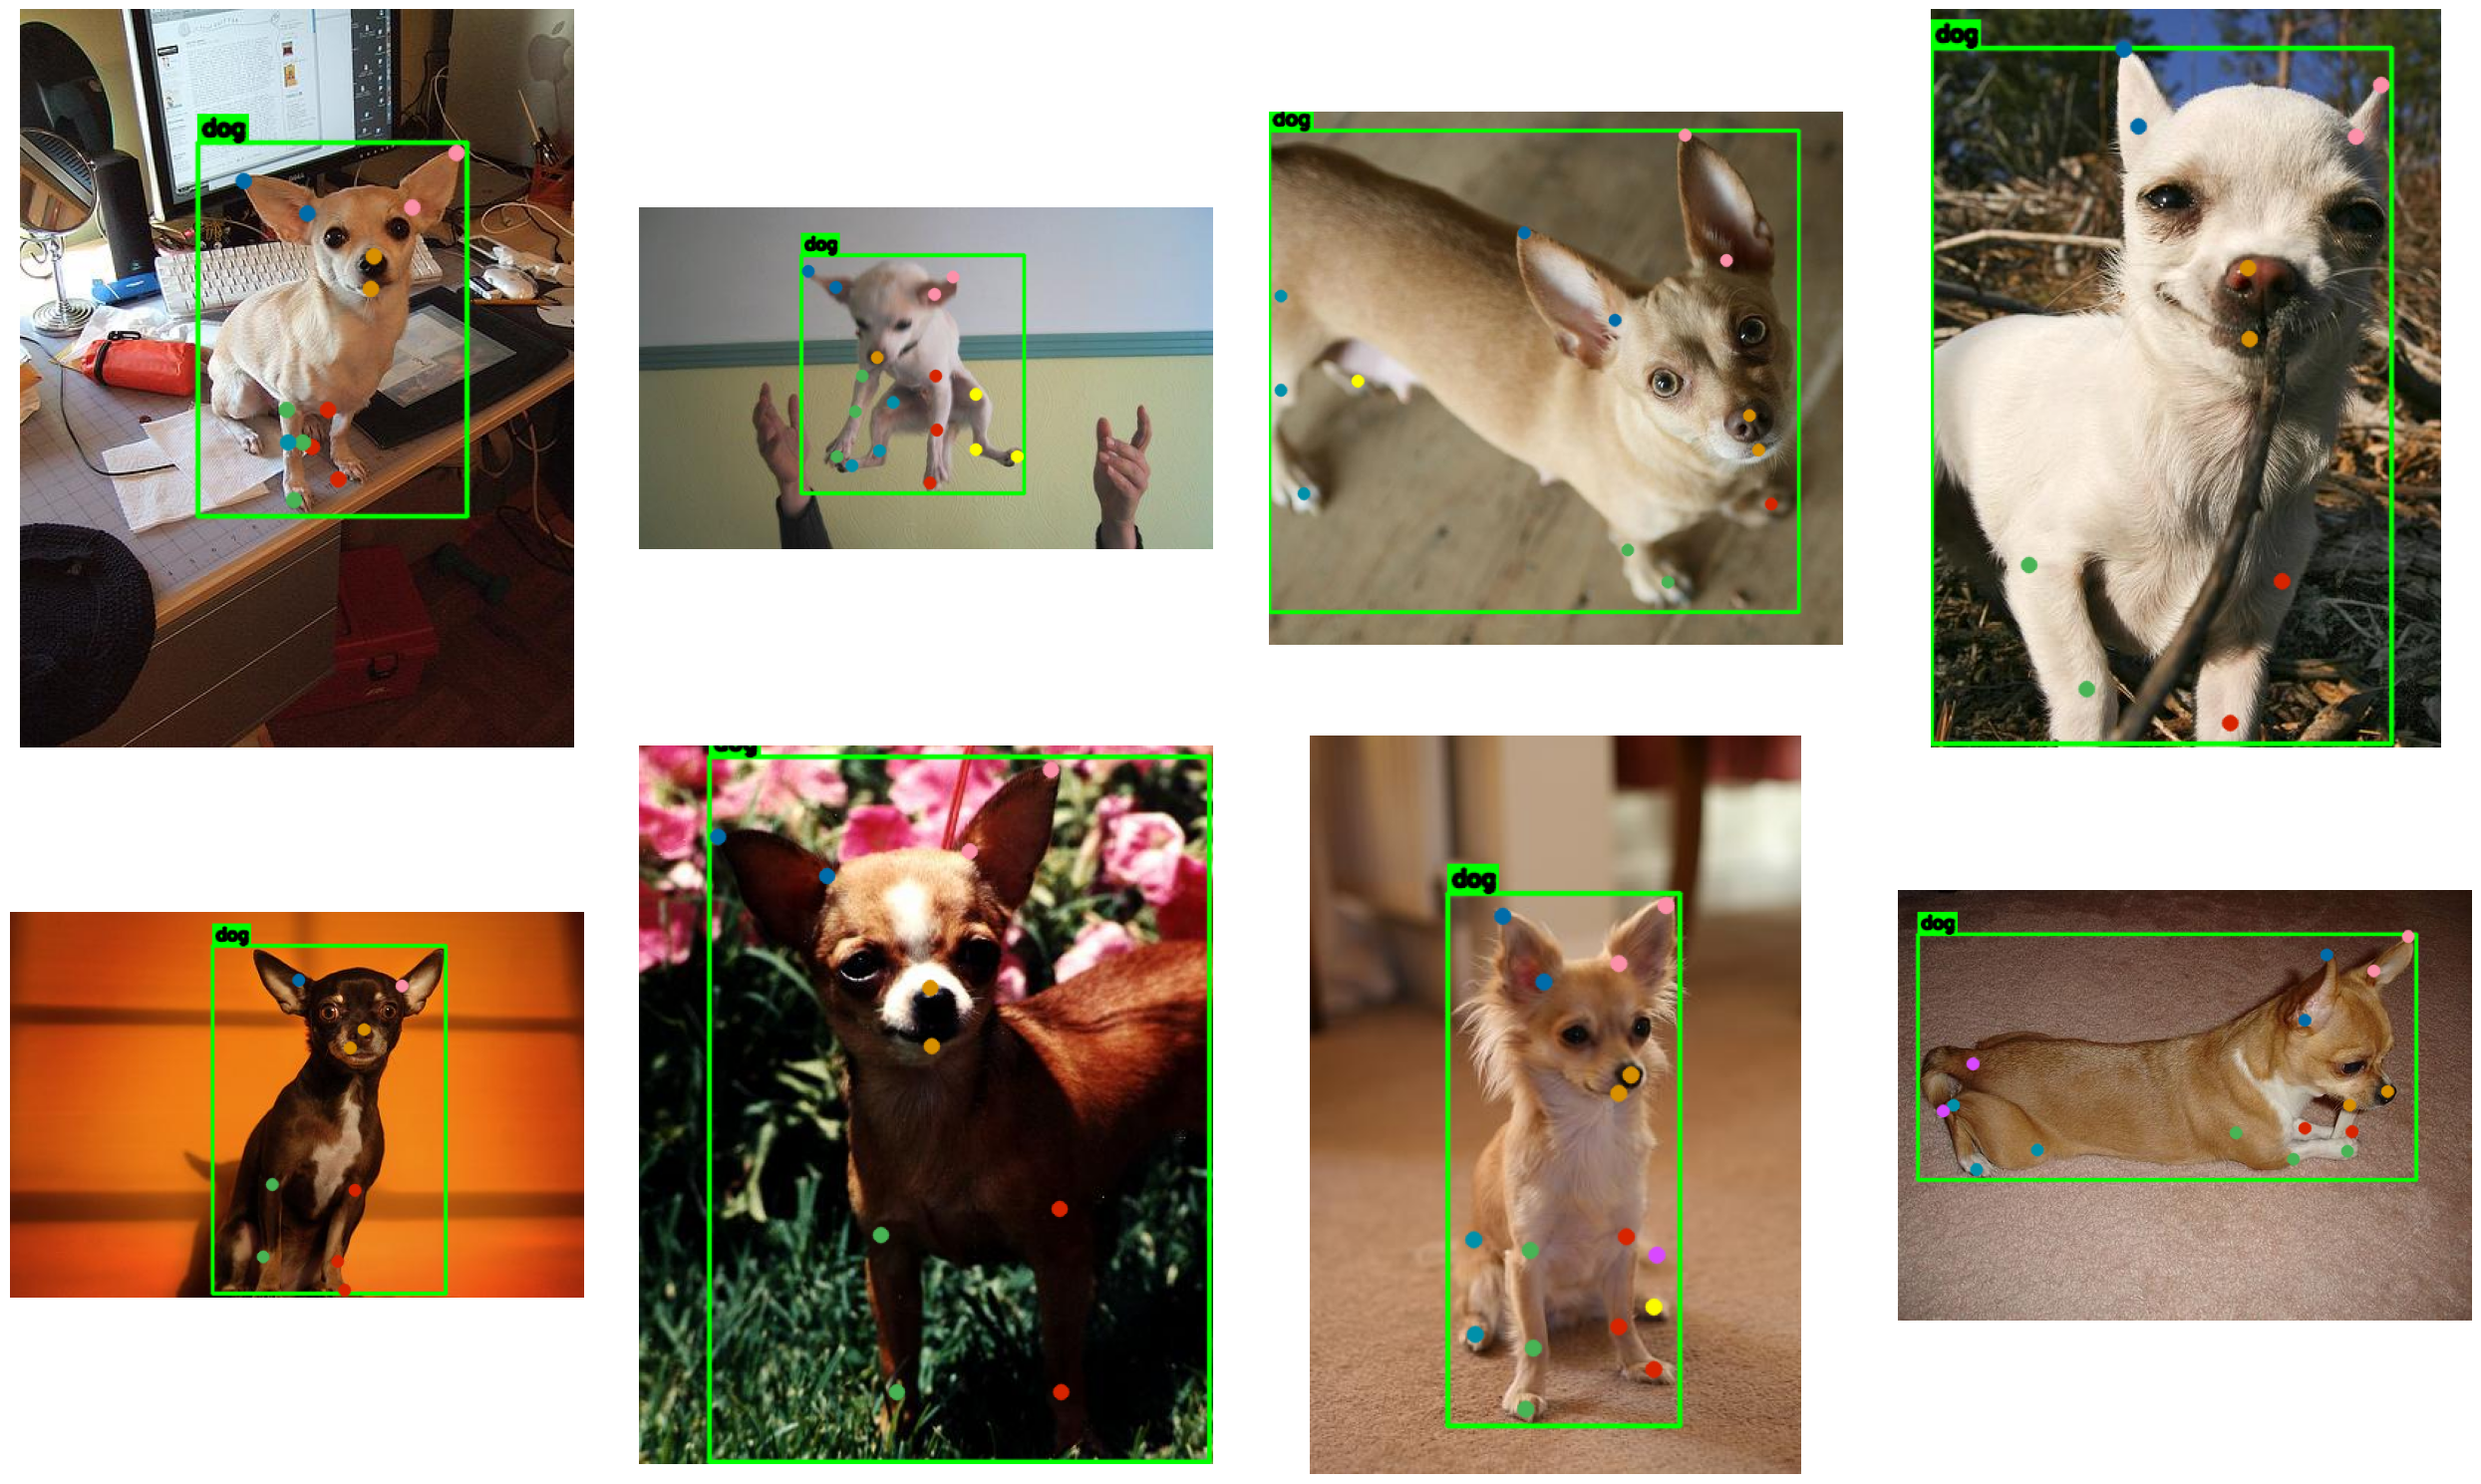

In [44]:
IMAGE_FILES = os.listdir(TRAIN_IMG_PATH)
NUM_LANDMARKS = 24

num_samples = 8
num_rows = 2
num_cols = num_samples//num_rows

fig, ax = plt.subplots(
        nrows=num_rows,
        ncols=num_cols,
        figsize=(25, 15),
    )

random.seed(45)
random.shuffle(IMAGE_FILES)

for idx, (file, axis) in enumerate(zip(IMAGE_FILES[:num_samples], ax.flat)):

    image = cv2.imread(os.path.join(TRAIN_IMG_PATH, file))

    # Obtain the txt file for the corresponding image file.
    filename = file.split(".")[0]
    # Split each object instance in separate lists.
    with open(os.path.join(TRAIN_LABEL_PATH, filename+".txt"), "r") as file:
        label_data = [x.split() for x in file.read().strip().splitlines() if len(x)]

    label_data = np.array(label_data, dtype=np.float32)

    # YOLO BBox instances in [x-center, y-center, width, height] in normalized form.
    box_instances = label_data[:,1:5]
    # Shape: (N, 4), where, N = #instances per-image

    # Kpt instances.
    # Filter keypoints based on visibility.
    instance_kpts = []
    kpts_data = label_data[:,5:].reshape(-1, NUM_LANDMARKS, 3)

    for inst_kpt in kpts_data:
        vis_ids = np.where(inst_kpt[:, -1]>0.)[0]
        vis_kpts = inst_kpt[vis_ids][:,:2]
        vis_kpts = np.concatenate([vis_kpts, np.expand_dims(vis_ids, axis=-1)], axis=-1)
        instance_kpts.append(vis_kpts)

    image_ann = visualize_annotations(image, box_instances, instance_kpts)
    axis.imshow(image_ann[...,::-1])
    axis.axis("off")


plt.tight_layout(h_pad=4., w_pad=4.)
plt.show()

## 5 Configurations

### 5.1 Training Configuration

We shall define the training configuration for fine-tuning in the `TrainingConfig` class.

In [45]:
@dataclass(frozen=True)
class TrainingConfig:
    DATASET_YAML:   str = "animal-keypoints.yaml"
    MODEL:          str = "yolov8m-pose.pt"
    EPOCHS:         int = 1
    KPT_SHAPE:    tuple = (24,3)
    PROJECT:        str = "Animal_Keypoints"
    NAME:           str = f"{MODEL.split('.')[0]}_{EPOCHS}_epochs"
    CLASSES_DICT:  dict = field(default_factory = lambda:{0 : "dog"})

### 5.2 Data Configuration

The `DatasetConfig` class takes in the various hyperparameters related to the data such as the image size and batch size to be used while training, along with the various augmentation probabilities such as Mosaic, horizontal flip, etc.

In [46]:
@dataclass(frozen=True)
class DatasetConfig:
    IMAGE_SIZE:    int   = 640
    BATCH_SIZE:    int   = 16
    CLOSE_MOSAIC:  int   = 10
    MOSAIC:        float = 0.4
    FLIP_LR:       float = 0.0 # Turn off horizontal flip.

In [47]:
train_config = TrainingConfig()
data_config = DatasetConfig()

Before we start our training, we need to create a `yaml` containing the path to the images and label files. We also need to specify the class names, starting from index=0 and the keypoint shape.

In [48]:
current_dir = os.getcwd()

data_dict = dict(
                path      = os.path.join(current_dir, DATA_DIR),
                train     = os.path.join(TRAIN_DIR, TRAIN_FOLDER_IMG),
                val       = os.path.join(VALID_DIR, VALID_FOLDER_IMG),
                names     = train_config.CLASSES_DICT,
                kpt_shape = list(train_config.KPT_SHAPE),
               )

with open(train_config.DATASET_YAML, "w") as config_file:
    yaml.dump(data_dict, config_file)

## 6 Training

In [49]:
pose_model = model = YOLO(train_config.MODEL)

pose_model.train(data    = train_config.DATASET_YAML,
            epochs       = train_config.EPOCHS,
            imgsz        = data_config.IMAGE_SIZE,
            batch        = data_config.BATCH_SIZE,
            project      = train_config.PROJECT,
            name         = train_config.NAME,
            close_mosaic = data_config.CLOSE_MOSAIC,
            mosaic       = data_config.MOSAIC,
            fliplr       = data_config.FLIP_LR
           )

100%|██████████| 50.8M/50.8M [00:01<00:00, 36.5MB/s]


New https://pypi.org/project/ultralytics/8.3.44 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.39 🚀 Python-3.8.20 torch-2.4.1 CPU (Apple M2)
engine/trainer: task=pose, mode=train, model=yolov8m-pose.pt, data=animal-keypoints.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=Animal_Keypoints, name=yolov8m-pose_1_epochs, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

train: Scanning /Users/matteotex/Documents/VSC/matteotex/animal_pose_estimation/quick_train_test/animal-pose-data/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 776.03it/s]

train: New cache created: /Users/matteotex/Documents/VSC/matteotex/animal_pose_estimation/quick_train_test/animal-pose-data/train/labels.cache



val: Scanning /Users/matteotex/Documents/VSC/matteotex/animal_pose_estimation/quick_train_test/animal-pose-data/valid/labels... 1703 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1703/1703 [00:01<00:00, 1693.81it/s]

val: WARNING ⚠️ /Users/matteotex/Documents/VSC/matteotex/animal_pose_estimation/quick_train_test/animal-pose-data/valid/images/n02089973_1763.jpg: corrupt JPEG restored and saved


val: New cache created: /Users/matteotex/Documents/VSC/matteotex/animal_pose_estimation/quick_train_test/animal-pose-data/valid/labels.cache
Plotting labels to Animal_Keypoints/yolov8m-pose_1_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 83 weight(decay=0.0), 93 weight(decay=0.0005), 92 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to Animal_Keypoints/yolov8m-pose_1_epochs
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      1.554      10.77     0.7179      3.315      2.131         14        640: 100%|██████████| 1/1 [00:12<00:00, 12.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [15:14<00:00, 16.93s/it]


                   all       1703       1703      0.123      0.116      0.052     0.0267          0          0          0          0

1 epochs completed in 0.260 hours.
Optimizer stripped from Animal_Keypoints/yolov8m-pose_1_epochs/weights/last.pt, 53.8MB
Optimizer stripped from Animal_Keypoints/yolov8m-pose_1_epochs/weights/best.pt, 53.8MB

Validating Animal_Keypoints/yolov8m-pose_1_epochs/weights/best.pt...
Ultralytics 8.3.39 🚀 Python-3.8.20 torch-2.4.1 CPU (Apple M2)
YOLOv8m-pose summary (fused): 237 layers, 26,743,003 parameters, 0 gradients, 82.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [16:19<00:00, 18.14s/it]


                   all       1703       1703      0.123      0.116      0.052     0.0267          0          0          0          0
Speed: 0.8ms preprocess, 569.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to Animal_Keypoints/yolov8m-pose_1_epochs


ultralytics.utils.metrics.PoseMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x3073effd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(P)', 'F1-Confidence(P)', 'Precision-Confidence(P)', 'Recall-Confidence(P)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.0

## 7 Evaluation

In [50]:
ckpt_path  = os.path.join(train_config.PROJECT, train_config.NAME, "weights", "best.pt")
model_pose = YOLO(ckpt_path)

metrics = model_pose.val()

Ultralytics 8.3.39 🚀 Python-3.8.20 torch-2.4.1 CPU (Apple M2)
YOLOv8m-pose summary (fused): 237 layers, 26,743,003 parameters, 0 gradients, 82.2 GFLOPs


val: Scanning /Users/matteotex/Documents/VSC/matteotex/animal_pose_estimation/quick_train_test/animal-pose-data/valid/labels.cache... 1703 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1703/1703 [00:00<?, ?it/s]

val: WARNING ⚠️ /Users/matteotex/Documents/VSC/matteotex/animal_pose_estimation/quick_train_test/animal-pose-data/valid/images/n02089973_1763.jpg: corrupt JPEG restored and saved



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 107/107 [20:27<00:00, 11.47s/it]


                   all       1703       1703      0.123      0.117      0.052     0.0268          0          0          0          0
Speed: 0.6ms preprocess, 715.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/pose/val


## 8 Predictions

The `prepare_predictions` function obtains the predicted boxes, confidence scores, and keypoints for the corresponding image.

In [51]:
def prepare_predictions(
    image_dir_path,
    image_filename,
    model,
    BOX_IOU_THRESH = 0.55,
    BOX_CONF_THRESH=0.30,
    KPT_CONF_THRESH=0.68):

    image_path = os.path.join(image_dir_path, image_filename)
    image = cv2.imread(image_path).copy()

    results = model.predict(image_path, conf=BOX_CONF_THRESH, iou=BOX_IOU_THRESH)[0].cpu()

    if not len(results.boxes.xyxy):
        return image

    # Get the predicted boxes, conf scores and keypoints.
    pred_boxes = results.boxes.xyxy.numpy()
    pred_box_conf = results.boxes.conf.numpy()
    pred_kpts_xy = results.keypoints.xy.numpy()
    pred_kpts_conf = results.keypoints.conf.numpy()

    # Draw predicted bounding boxes, conf scores and keypoints on image.
    for boxes, score, kpts, confs in zip(pred_boxes, pred_box_conf, pred_kpts_xy, pred_kpts_conf):
        kpts_ids = np.where(confs > KPT_CONF_THRESH)[0]
        filter_kpts = kpts[kpts_ids]
        filter_kpts = np.concatenate([filter_kpts, np.expand_dims(kpts_ids, axis=-1)], axis=-1)
        image = draw_boxes(image, boxes, score=score)
        image = draw_landmarks(image, filter_kpts)

    return image


image 1/1 /Users/matteotex/Documents/VSC/matteotex/animal_pose_estimation/quick_train_test/animal-pose-data/valid/images/n02107142_9621.jpg: 480x640 (no detections), 244.0ms
Speed: 1.1ms preprocess, 244.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /Users/matteotex/Documents/VSC/matteotex/animal_pose_estimation/quick_train_test/animal-pose-data/valid/images/n02095889_6307.jpg: 640x544 1 dog, 248.4ms
Speed: 1.4ms preprocess, 248.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /Users/matteotex/Documents/VSC/matteotex/animal_pose_estimation/quick_train_test/animal-pose-data/valid/images/n02100877_2675.jpg: 640x448 (no detections), 211.3ms
Speed: 1.4ms preprocess, 211.3ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /Users/matteotex/Documents/VSC/matteotex/animal_pose_estimation/quick_train_test/animal-pose-data/valid/images/n02106382_1048.jpg: 640x448 (no detections), 208.9ms
Speed: 1.0ms pre

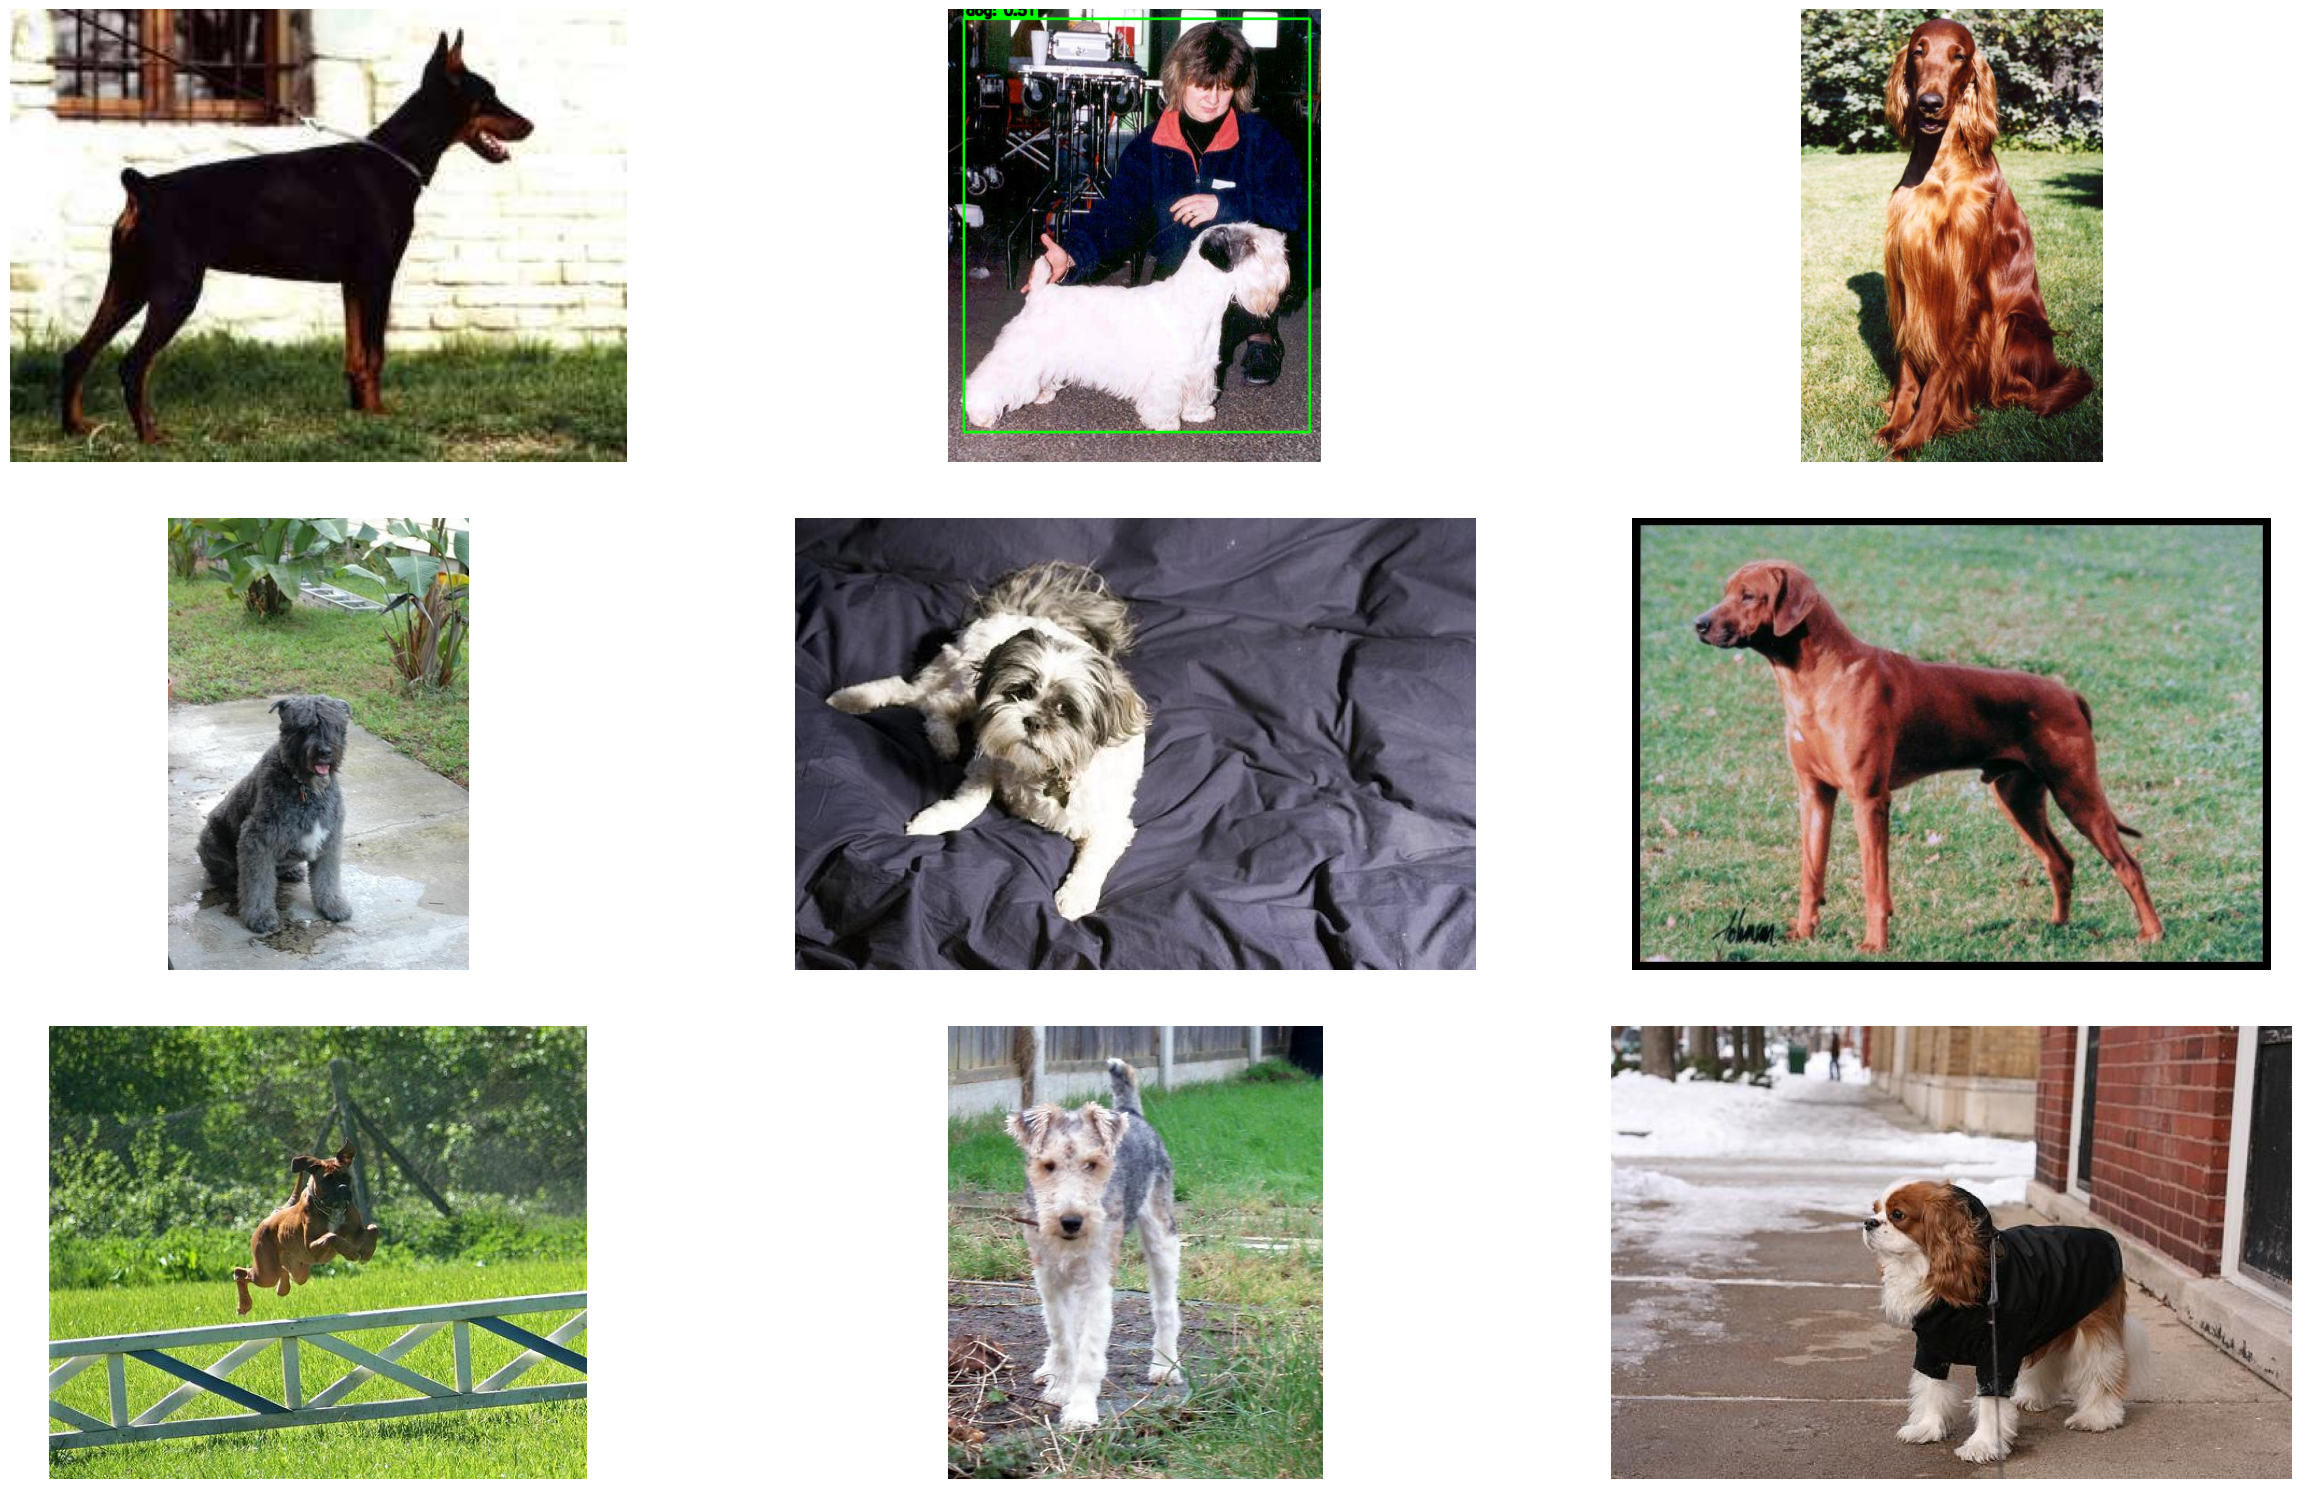

In [52]:
VAL_IMAGE_FILES = os.listdir(VALID_IMG_PATH)

num_samples = 9
num_rows = 3
num_cols = num_samples//num_rows

fig, ax = plt.subplots(
        nrows=num_rows,
        ncols=num_cols,
        figsize=(25, 15),
    )

random.seed(90)
random.shuffle(VAL_IMAGE_FILES)

for idx, (file, axis) in enumerate(zip(VAL_IMAGE_FILES[:num_samples], ax.flat)):

    image_pred = prepare_predictions(VALID_IMG_PATH, file, model_pose)
    axis.imshow(image_pred[...,::-1])
    axis.axis("off")

plt.tight_layout(h_pad=4., w_pad=4.)
plt.show();

FINAL NOTES : 

10 images, 1 epoch.
Roughly 30 minutes hardcore job and no good results obtained.
Probably 100 epochs will be ok with even small dataset (100 images)
Better to test this on the dell laptop